In [1]:
import numpy as np
import scipy


def generate_parameters(n=10, max_logit=2, max_count=20, logit_mean=0.1):
    logits = logit_mean + np.random.uniform(-max_logit, max_logit, n)
    probabilities = scipy.special.expit(logits).round(2)
    counts = 1 + np.random.exponential(scale=max_count, size=n).astype(int)
    return probabilities, counts

generate_parameters()

(array([0.85, 0.24, 0.35, 0.55, 0.23, 0.42, 0.25, 0.45, 0.18, 0.88]),
 array([20,  6,  5,  4,  8, 40, 42, 23, 73, 31]))

In [2]:
def generate_experiments(k=1000, **kwargs):
    probabilities, counts = generate_parameters(**kwargs)
    
    target = []
    for p, c in zip(probabilities, counts):
        target.append(
            np.random.binomial(n=c, p=p, size=k)
        )
    target = np.column_stack(target)
    total = np.column_stack([counts] * k).T

    return target, total, probabilities

target, total, probabilities = generate_experiments(1000)

In [3]:
def get_optimal(target, total, probabilities):
    return [np.argmax(probabilities)] * total.shape[0]

np.mean(probabilities[get_optimal(target, total, probabilities)]).round(3)

0.89

In [4]:
def get_argmax(target, total, probabilities):
    return np.argmax(target / total, axis=1)

np.mean(probabilities[get_argmax(target, total, probabilities)]).round(3)

0.797

In [5]:
def get_random(target, total, probabilities):
    return np.random.randint(0, total.shape[1] - 1, total.shape[0])

np.mean(probabilities[get_random(target, total, probabilities)]).round(3)

0.595

In [6]:
strategies = [get_random, get_argmax, get_optimal]

In [13]:
import pandas as pd
from tqdm.auto import tqdm
from joblib import Parallel, delayed, wrap_non_picklable_objects
import itertools
from functools import partial


def check_strategies_once(strategies=[get_random, get_optimal], n_set=[10, 100, 1000], **kwargs):
    results = []

    for n in n_set:
        target, total, probabilities = generate_experiments(n=n, **kwargs)
        experiment_result = {'n': n}
        rank = pd.Series(probabilities).rank(ascending=False, method='first').values
        rank = (rank - 1) / rank.shape[0]
        for strategy in strategies:
            name = ''
            try:
                name = strategy.__name__
            except AttributeError:
                name = f'{strategy.func.__name__}:{strategy.keywords}'

            score = np.mean(probabilities[strategy(target, total, probabilities)])
            mean_rank = np.mean(rank[strategy(target, total, probabilities)])
            experiment_result[name] = score
            experiment_result[f'{name}_rank'] = mean_rank
        results.append(experiment_result)
    return results

def check_strategies_multi(strategies=[get_random, get_optimal], n_set=[10, 100, 1000], n_repeats=10, **kwargs):
    results = []
    print(n_set)

    results = Parallel(n_jobs=-1, verbose=1)(delayed(check_strategies_once)(
        strategies=strategies, n_set=n_set, **kwargs
    ) for i in tqdm(range(n_repeats)))

    return list(itertools.chain.from_iterable(results))

def get_argmax_std_diff(target, total, probabilities, alpha=1.0):
    p_estimate = target / total
    q_estimate = 1 - p_estimate
    std = p_estimate * (1 - q_estimate) / total
    return np.argmax(p_estimate - std * alpha, axis=1)

strategies = [get_argmax, get_optimal] # get_random
for alpha in np.linspace(1.0, 3.0, 11):
    s = partial(get_argmax_std_diff, alpha=alpha)
    strategies.append(
        s
    )

results = check_strategies_multi(
    strategies=strategies, 
    n_set=np.logspace(1, 4, 50).astype(int),
    max_logit=3,
    k=1000,
    n_repeats=80,
)

[   10    11    13    15    17    20    23    26    30    35    40    47
    54    62    71    82    95   109   126   145   167   193   222   255
   294   339   390   449   517   596   686   790   910  1048  1206  1389
  1599  1842  2120  2442  2811  3237  3727  4291  4941  5689  6551  7543
  8685 10000]


  0%|          | 0/80 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 25.8min finished


In [14]:
results = pd.DataFrame(results).set_index('n').sort_index()
results.sample(3).T

n,26,17,82
get_argmax,0.852520,0.880140,0.668380
get_argmax_rank,0.115962,0.057529,0.291012
get_optimal,0.930000,0.950000,0.950000
get_optimal_rank,0.000000,0.000000,0.000000
get_argmax_std_diff:{'alpha': 1.0},0.885500,0.941310,0.930230
get_argmax_std_diff:{'alpha': 1.0}_rank,0.069769,0.007706,0.048329
get_argmax_std_diff:{'alpha': 1.2},0.886290,0.943970,0.930310
get_argmax_std_diff:{'alpha': 1.2}_rank,0.068808,0.005294,0.047683
get_argmax_std_diff:{'alpha': 1.4},0.886550,0.947470,0.930400
get_argmax_std_diff:{'alpha': 1.4}_rank,0.068538,0.002176,0.047524


In [15]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

In [16]:
results[[s for s in results.columns if s.endswith('_rank')]].mean(axis=0).T.sort_values().round(4)

get_optimal_rank                                          0.0000
get_argmax_std_diff:{'alpha': 1.6}_rank                   0.0589
get_argmax_std_diff:{'alpha': 1.8}_rank                   0.0590
get_argmax_std_diff:{'alpha': 1.4}_rank                   0.0591
get_argmax_std_diff:{'alpha': 2.0}_rank                   0.0592
get_argmax_std_diff:{'alpha': 1.2}_rank                   0.0594
get_argmax_std_diff:{'alpha': 2.2}_rank                   0.0595
get_argmax_std_diff:{'alpha': 1.0}_rank                   0.0599
get_argmax_std_diff:{'alpha': 2.4000000000000004}_rank    0.0600
get_argmax_std_diff:{'alpha': 2.6}_rank                   0.0605
get_argmax_std_diff:{'alpha': 2.8}_rank                   0.0610
get_argmax_std_diff:{'alpha': 3.0}_rank                   0.0616
get_argmax_rank                                           0.1809
dtype: float64

In [17]:
results[[s for s in results.columns if not s.endswith('_rank')]].mean(axis=0).T.sort_values().round(4)

get_argmax                                           0.8352
get_argmax_std_diff:{'alpha': 3.0}                   0.9307
get_argmax_std_diff:{'alpha': 2.8}                   0.9310
get_argmax_std_diff:{'alpha': 2.6}                   0.9314
get_argmax_std_diff:{'alpha': 2.4000000000000004}    0.9316
get_argmax_std_diff:{'alpha': 2.2}                   0.9319
get_argmax_std_diff:{'alpha': 1.0}                   0.9320
get_argmax_std_diff:{'alpha': 2.0}                   0.9321
get_argmax_std_diff:{'alpha': 1.2}                   0.9322
get_argmax_std_diff:{'alpha': 1.8}                   0.9323
get_argmax_std_diff:{'alpha': 1.4}                   0.9323
get_argmax_std_diff:{'alpha': 1.6}                   0.9323
get_optimal                                          0.9540
dtype: float64

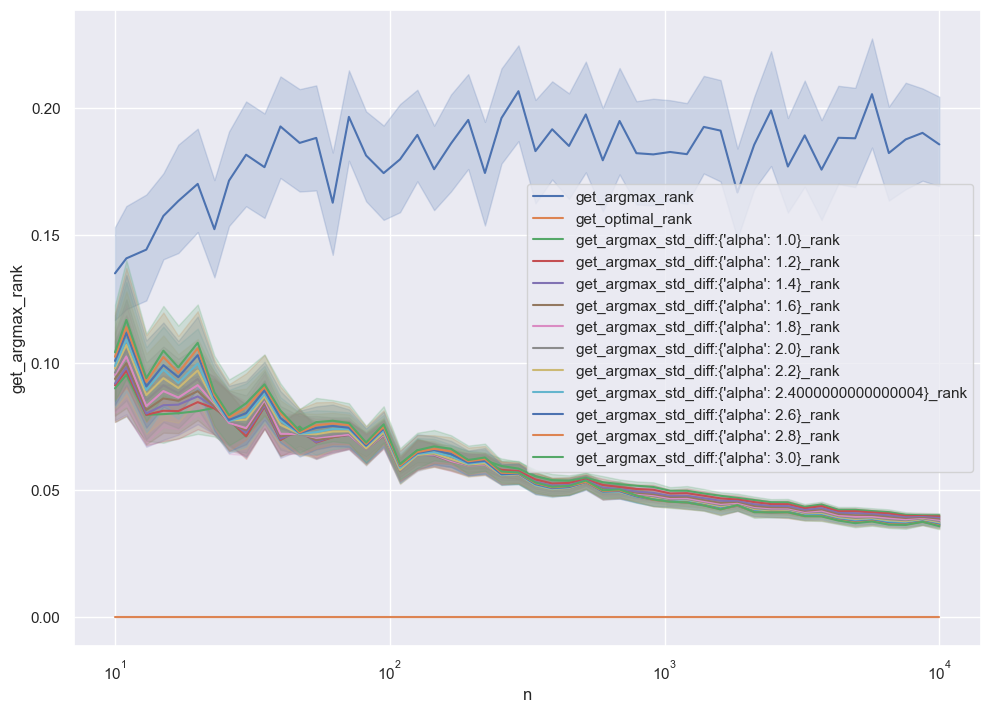

In [18]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

for strategy_name in [s for s in results.columns if s.endswith('_rank')]:
    plot = seaborn.lineplot(results, x='n', y=strategy_name, label=strategy_name)
    plot.set(xscale='log')

_ = plt.legend()

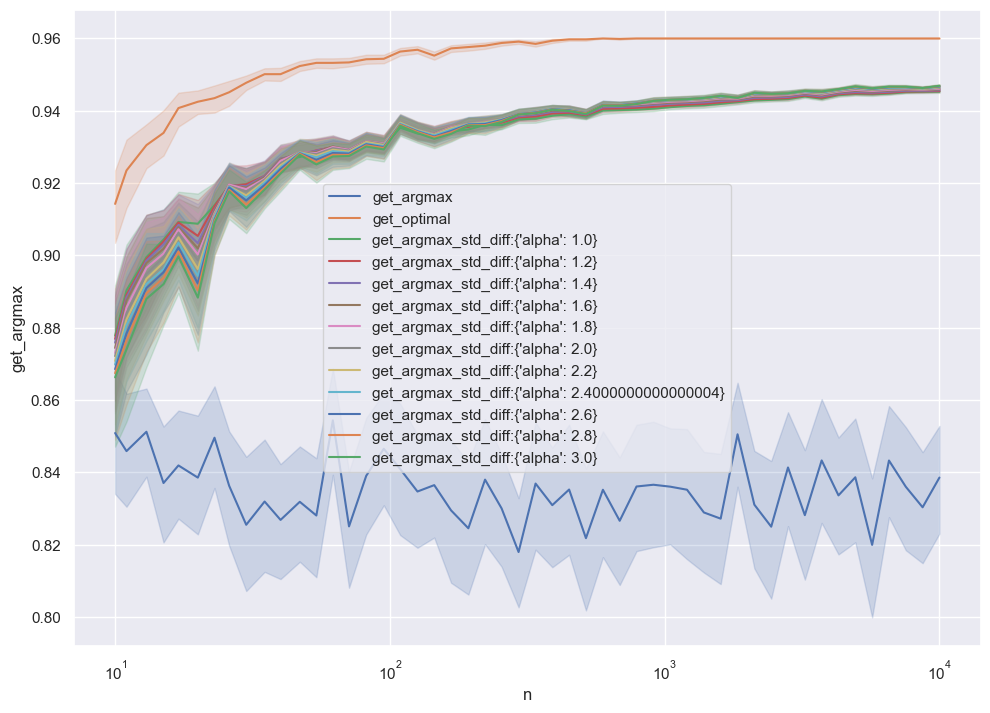

In [19]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

for strategy_name in [s for s in results.columns if not s.endswith('_rank')]:
    plot = seaborn.lineplot(results, x='n', y=strategy_name, label=strategy_name)
    plot.set(xscale='log')

_ = plt.legend()